# This will take user comments that have been moderated and do analysis on them to understand what types of comments people are writing and identity what gets moderated by human moderators

In [145]:
# imports for the math and data processing packages we will need

import pandas as pd, numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

In [189]:
#Data Import, ref data from https://www.kaggle.com/areeves87/rscience-popular-comment-removal
file1 = "/Users/robjohns/Data/Metis/RedditComments/reddit_200k_train.csv"
file2 = "/Users/robjohns/Data/Metis/RedditComments/reddit_200k_test.csv"

train = pd.read_csv(file1,encoding='latin-1')
test = pd.read_csv(file2,encoding='latin-1')

In [190]:
len(train),len(test)

(167529, 55843)

In [191]:
train.head()

,Unnamed: 0,body,score.x,parent_id.x,id,created_utc.x,retrieved_on,REMOVED
0,1,I've always been taught it emerged from the ea...,2,t3_81u15i,dv551g6,1520121101,1524782256,False
1,2,"As an ECE, my first feeling as ""HEY THAT'S NOT...",2,t3_72sk35,dnl66g6,1506533157,1507150439,True
2,3,Monday: Drug companies stock dives on good new...,5,t3_8o88yr,e02sjhz,1528087570,1532170350,True
3,4,i learned that all hybrids are unfertile i won...,0,t3_6xg9t8,dmfojjp,1504290041,1506407514,False
4,5,Well i was wanting to get wasted tonight. Not...,3,t3_99wi9m,e4rtew8,1535140675,1537893540,False


In [192]:
# even though the reddit dataset was formatted as train and test, what we care about is doing unsupervised analysis
# so lets combine them into a big data set.  Also, later I want to see if topic analysis will come up with new 
# insights if it runs on ONLY moderated or unmoderated comments so I will make some masked dataframes for that
# analysis too

Big_df=pd.concat([train, test], ignore_index=True)

ok_mask = Big_df['REMOVED'] == False
not_ok_mask = Big_df['REMOVED'] == True


Ok_comments=Big_df[ok_mask]
Not_ok_comments=Big_df[not_ok_mask]


In [193]:
len(Big_df),len(Ok_comments),len(Not_ok_comments)

(223372, 137356, 86016)

In [194]:
Big_df.head()

,Unnamed: 0,body,score.x,parent_id.x,id,created_utc.x,retrieved_on,REMOVED
0,1,I've always been taught it emerged from the ea...,2,t3_81u15i,dv551g6,1520121101,1524782256,False
1,2,"As an ECE, my first feeling as ""HEY THAT'S NOT...",2,t3_72sk35,dnl66g6,1506533157,1507150439,True
2,3,Monday: Drug companies stock dives on good new...,5,t3_8o88yr,e02sjhz,1528087570,1532170350,True
3,4,i learned that all hybrids are unfertile i won...,0,t3_6xg9t8,dmfojjp,1504290041,1506407514,False
4,5,Well i was wanting to get wasted tonight. Not...,3,t3_99wi9m,e4rtew8,1535140675,1537893540,False


In [195]:
# I want to only treat the text for now, i can join back onto descriptors later if i desire
Big_text= Big_df.drop(['Unnamed: 0','score.x','parent_id.x','id','created_utc.x','retrieved_on','REMOVED'],axis=1)
ok_text= Ok_comments.drop(['Unnamed: 0','score.x','parent_id.x','id','created_utc.x','retrieved_on','REMOVED'],axis=1)
not_ok_text=Not_ok_comments.drop(['Unnamed: 0','score.x','parent_id.x','id','created_utc.x','retrieved_on','REMOVED'],axis=1)

In [196]:
#lets make sure everything is stripped but text
test_text.head()

,body
0,"Hi Larpo_Nadar, your submission has been remov..."
1,"So out of every 10,000 children with autism wh..."
2,"When I was pregnant, I was warned against eati..."
3,Imagine if this find was the bug that eradicat...
4,Is it a myth that the math says it would take ...


In [158]:
len(Big_text),len(ok_text),len(not_ok_text)

(223372, 137356, 86016)

In [159]:
lens = Big_text.body.str.len()

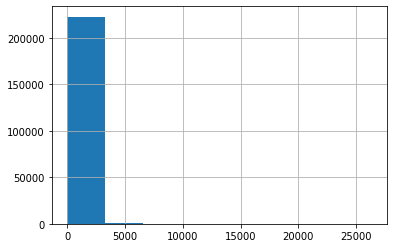

In [161]:
lens.hist(bins=8)

In [197]:
n = Big_text.shape[0]
vec = TfidfVectorizer(ngram_range=(1,3), tokenizer=None,
               min_df=32, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words='english' )
Big_term_doc = vec.fit_transform(Big_text['body'])
ok_term_doc = vec.transform(ok_text['body'])
not_ok_term_doc = vec.transform(not_ok_text['body'])

In [198]:
Big_term_doc

<223372x17212 sparse matrix of type '<class 'numpy.float64'>'
	with 4124041 stored elements in Compressed Sparse Row format>

In [165]:
ok_term_doc

<137356x18212 sparse matrix of type '<class 'numpy.float64'>'
	with 3073594 stored elements in Compressed Sparse Row format>

In [166]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [199]:
topics=25
indexer=[]
for _ in range(0,topics):
    indexer.append(f'comp{_}')

In [170]:
nmf_model = NMF(topics)
Big_topic = nmf_model.fit_transform(Big_term_doc)

In [182]:
nmf_model = NMF(topics)
ok_topic=nmf_model.fit_transform(ok_term_doc)
Big_topic=ok_topic

In [200]:
nmf_model = NMF(topics)
not_ok_topic=nmf_model.fit_transform(not_ok_term_doc)
Big_topic=not_ok_topic

In [186]:
# if you want the full topic to word correlation matrix here it is. . . . 

topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = indexer,
             columns = vec.get_feature_names())
topic_word

00    000  000 000  000 people  000 year  000 year old  000 years  \
comp0   0.034  0.196    0.009       0.003     0.017         0.010      0.115   
comp1   0.000  0.000    0.000       0.000     0.000         0.000      0.000   
comp2   0.002  0.001    0.000       0.000     0.000         0.000      0.002   
comp3   0.000  0.000    0.000       0.000     0.000         0.000      0.000   
comp4   0.000  0.000    0.000       0.000     0.000         0.000      0.000   
comp5   0.000  0.009    0.002       0.016     0.000         0.000      0.000   
comp6   0.001  0.000    0.000       0.000     0.000         0.000      0.000   
comp7   0.001  0.000    0.000       0.000     0.000         0.000      0.000   
comp8   0.000  0.000    0.000       0.000     0.000         0.000      0.000   
comp9   0.000  0.000    0.002       0.000     0.000         0.000      0.000   
comp10  0.000  0.002    0.000       0.002     0.000         0.000      0.000   
comp11  0.000  0.005    0.000       0.000     0.000         0.000      0.000   
comp12  0.000  0.000    0.000       0.000     0.000         0.000      0.000   
comp13  0.000  0.000    0.000       0.000     0.000         0.000      0.000   
comp14  0.000  0.001    0.000       0.000     0.000         0.000      0.000   
comp15  0.000  0.006    0.000       0.001     0.002         0.003      0.002   
comp16  0.000  0.000    0.000       0.000     0.000         0.000      0.000   
comp17  0.000  0.000    0.000       0.000     0.000         0.000      0.000   
comp18  0.006  0.000    0.001       0.000     0.000         0.000      0.000   
comp19  0.002  0.000    0.000       0.000     0.000         0.000      0.000   
comp20  0.000  0.000    0.000       0.000     0.001         0.001      0.000   
comp21  0.000  0.000    0.000       0.000     0.000         0.000      0.000   
comp22  0.000  0.000    0.001       0.000     0.000         0.000      0.000   
comp23  0.004  0.000    0.000       0.000     0.000         0.000      0.000   
comp24  0.000  0.002    0.000       0.001     0.000         0.000      0.000   

        000 years ago  000 years old  0001  0001f602  0001f914    001  \
comp0           0.040          0.057   0.0     0.008     0.013  0.000   
comp1           0.000          0.000   0.0     0.000     0.000  0.000   
comp2           0.000          0.000   0.0     0.005     0.000  0.000   
comp3           0.000          0.000   0.0     0.001     0.003  0.000   
comp4           0.000          0.000   0.0     0.000     0.001  0.000   
comp5           0.000          0.000   0.0     0.000     0.007  0.000   
comp6           0.000          0.000   0.0     0.002     0.000  0.000   
comp7           0.000          0.000   0.0     0.005     0.000  0.001   
comp8           0.000          0.000   0.0     0.001     0.000  0.001   
comp9           0.000          0.000   0.0     0.004     0.000  0.000   
comp10          0.000          0.000   0.0     0.011     0.007  0.000   
comp11          0.000          0.000   0.0     0.000     0.002  0.000   
comp12          0.000          0.000   0.0     0.000     0.002  0.000   
comp13          0.000          0.000   0.0     0.013     0.000  0.000   
comp14          0.000          0.000   0.0     0.000     0.000  0.000   
comp15          0.001          0.000   0.0     0.024     0.009  0.000   
comp16          0.000          0.000   0.0     0.000     0.007  0.000   
comp17          0.000          0.000   0.0     0.000     0.000  0.000   
comp18          0.000          0.000   0.0     0.004     0.000  0.000   
comp19          0.000          0.000   0.0     0.002     0.000  0.000   
comp20          0.000          0.000   0.0     0.002     0.012  0.000   
comp21          0.000          0.000   0.0     0.000     0.003  0.000   
comp22          0.000          0.000   0.0     0.014     0.002  0.000   
comp23          0.000          0.000   0.0     0.000     0.000  0.000   
comp24          0.000          0.000   0.0     0.010     0.006  0.001   

        001 abstract    002  00

In [201]:
display_topics(nmf_model, vec.get_feature_names(), 10)


Topic  0
time, life, going, think, way, ve, day, got, kids, better

Topic  1
removed, comments removed, comment, comment removed, posts, thread, removed removed, removed posts, thread removed, comment section

Topic  2
science, sub, political, social, isn, social science, politics, isn science, subreddit, settled

Topic  3
like, feel, feel like, looks, looks like, just like, don like, look like, look, like people

Topic  4
reddit, post, flair, message, mods, flair post, reddit com, www reddit, www reddit com, submission removed

Topic  5
people, people don, think, stupid, believe, poor, white, people think, people just, white people

Topic  6
fuck, don fuck, mods, happened, comment, gonna, shut, fuck shit, did, stupid

Topic  7
don, want, don want, don know, care, don care, don think, people don, believe, think

Topic  8
just, just like, just want, people just, just don, eat, maybe, just need, want, just eat

Topic  9
shit, like shit, eat, oh shit, sherlock, eat shit, sub, file, stop,

In [174]:
H = pd.DataFrame(Big_topic.round(5),columns = indexer)


In [176]:
Removal_df = pd.concat([H,Big_df], axis=1)

In [177]:
Removal_group=Removal_df.groupby(['REMOVED']).mean()

In [178]:
pd.set_option('display.max_columns', 999)

In [179]:
Removal_group

,comp0,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,comp9,comp10,comp11,comp12,comp13,comp14,comp15,comp16,comp17,comp18,comp19,comp20,comp21,comp22,comp23,comp24,Unnamed: 0,score.x,created_utc.x,retrieved_on
REMOVED,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0.004648,0.001503,0.002472,0.003017,0.003258,0.001484,0.000514,0.002932,0.002449,0.002174,0.002430,0.001936,0.001889,0.001855,0.001020,0.000908,0.002067,0.001493,0.001177,0.002098,0.001158,0.000745,0.001075,0.001423,0.001943,69787.816870,48.876576,1.512029e+09,1.514111e+09
True,0.003676,0.000872,0.000533,0.003056,0.003322,0.001746,0.001947,0.003223,0.001498,0.002564,0.001916,0.002156,0.001363,0.001802,0.000326,0.001223,0.001703,0.001972,0.001198,0.001945,0.000340,0.001821,0.001216,0.001920,0.002105,69830.491502,30.801642,1.510797e+09,1.512821e+09
